# MNIST - teaching computers to read

First lets enable and check GPUs are working on this notebook. Should shave a few secs-mins off training time later

In [0]:
# GPU setup
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

# sess.close()


Teaching computers to see numbers with fancy math.

In tensorflow we first outline and create computational graphs and then execute them.

Think of a written number input to a computer. It's 28x28 pixels We can unroll this into a simpler vector which still retains identifying information. e.g. A 8 has more lines and dark spaces than a 0.

In [0]:
import random
total = []
for i in range(0, 10):
  ex = []
  for i in range(0, 10):
    n = random.randint(0, 1)
    ex.append(n)
    total.append(n)
  print(ex)

print('Unrolled to:')
  
print(total)

[0, 0, 1, 1, 1, 0, 0, 1, 0, 1]
[1, 1, 1, 1, 0, 0, 1, 1, 0, 1]
[1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
[1, 1, 0, 0, 1, 0, 0, 1, 0, 1]
[1, 1, 0, 1, 1, 1, 1, 0, 0, 1]
[0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
[1, 1, 0, 0, 0, 0, 0, 1, 0, 1]
[1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 0, 0, 0, 0, 1]
Unrolled to:
[0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1]


First we need to get the training data. MNIST is just a large set of handwritten numbers someone painstakingly labelled.

Tensorflow provides some nice convenient builtins for this. 

Note: The input data comes in as one_hot vectors, i.e. they're large swaths of 0s with >0s where the black marks are for numbers. These are unrolled from their normal shape into a linear shape of 768pixels 

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import math


DATA_DIR = '/tmp/data'
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


We create a placeholder to store our inputs, and a variable that will evolve with training to better predict the outcome

We use a linear function to then map our simplified input into evidence. 

We also add a bias so we can say that some things are more independent of the input

This is simply doing a matrix multiplication. 


In [0]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
x = tf.placeholder(tf.float32, [None, 784])

y = tf.matmul(x, W) + b

Next lets set up a placeholder to hold data incoming from the labels that we can use to refine and train our model.
For this we set up another placeholder with an unknown length but a shape of 10 since we have 10 distinct digits

In [0]:
y_ = tf.placeholder(tf.float32, [None, 10])

The next step is to set up the training. 
We use softmax with logits to map our linear model into the shape we want, a probability distribution over 10 classes. 

Softmax is a generalized variant of logistic regression and instead of mapping to a binary output it maps to different classes 

A logit is an inverse sigmoid which maps from a linear 0/1 to a bernoulli probability distribtion. 

The next step is implementing the cross entropy function, which derives the differences between our model outputs and the ground truth. A lower cross entropy in this case means we are closer to the truth

In [0]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

Now that we've defined the computational graph:
input -> unroll -> matmul -> softmax -> output

We can set up the training mechanism. 

For this we'll use gradient descent, optimizing for a reduction in cross entropy.
GD is basically a glorified chain rule that works via backwards propagation instead of forward propagation due to mathmetical effeciencies. This will walk our computational graph generating derivatives to track how every node affects one output. 

We use GD with a learning rate of 0.5 and tensorflow will slowly shift the variables towards the direction we want. 
A higher learning rate may make us overshoot our ideal weights, a lower one may leave us stuck in a local minima or take forever. 

In [0]:
gd_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Now all that's left to do is create a tensorflow session and execute our graph.

We apply parameters for the number of steps we want to use and the batch size for training i.e. how many random data points we get from our training set each step. Larger batch sizes and number of steps can lead to more accurate models


In [0]:
def train_and_check(NUM_STEPS, MINIBATCH_SIZE):
  with tf.device('/gpu:0'):
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    for _ in range(NUM_STEPS):
      batch_xs, batch_ys = mnist.train.next_batch(MINIBATCH_SIZE)
      sess.run(gd_step, feed_dict={x: batch_xs, y_: batch_ys})
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    res = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
    print res
  return res

In [0]:
NUM_STEPS = 3000
MINIBATCH_SIZE = 100

steps = 1000
batch = 116

res = []
data = {}

accuracy = train_and_check(steps, batch)

# for i in range(100, 120):
#     print 'results for %d steps and %d batch size' % (NUM_STEPS, i)
#     accuracy = train_and_check(stepsi, batchi)
#     data.update({accuracy: {'steps': stepsi, 'batch': batchi}})


0.9205


Now lets see how we did. Probably 92%

I wonder how model params affect accuracy
TODO: plot 

In [0]:
# correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
import matplotlib.pyplot as plt
print 'Accuracy vs step size'

# print steps
# plt.plot([v['steps'] for v in data.values() if v['batch'] == 144], [k in data.keys()])
# plt.show()

# print('Accuracy vs batch size')
# plt.plot([v['batch'] for v in data.values() if v['steps'] == 900], data.keys())
# plt.show()


# plt.plot(data.values(), data.keys())
# plt.show()

Accuracy vs step size
100


NameError: ignored

# Deep MNIST

But the machine learning gods are displeased with 92%. And we dont want to piss of our eventual AI overlords so lets see if we can do better

We'll dive a bit deeper and explore a multilayer convolutional network≥

The human brain is a place of chaos and noise, and this keeps us sane. So we'll do the same here to prevent overfitting. 

We'll be using ReLu (rectified linear unit) neurons with a small amount of noise and a slight positive intial bias to make sure theyre all alive and happy.

In [0]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Next up is convolution and pooling. 
A biologically inspired if naive way to think of convolutions is the effect of your environment on you. 
We can draw an example from neuroscience wherein the firing of a single neuron is affected by the activation and states of the neurons around it, with many stimuli converging to either create or inhibit a response. 

Alternatively it's the smoothing or smearing effect of one function on another.

We convolute with a stride size of 1, 1 step at a time, and pad the output to maintain the same shape

In [0]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Ah pooling, here's my naive implementation of maxpool: [maxpool.py](https://github.com/kaustavha/cs_homeschool/blob/master/learn_algos/maxpool.py)

The gist of it is, given a large matrix we move across with a preset sliding window size, gathering the max value in each window, thereby reducing the matrix

In [0]:
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

Now we can start building our CNN layer 1.  
We setup our neurons weights and bias.  

This layer will compute 32 output features for each 5x5 patch of the incoming tensor. We'll have one input channel into the neuron, and output channels equal to the number of features we compute. You can think of features are important or distinguishing characteristics in the image. 

We also create a bias variable with the shape of our output feature set. 

I think of this similiar to a biological neuron convoluting incoming visual info and sending it forward to different neurons for different purposes. Someone with terrible handwriting will probably understand bad handwriting better, and neurons wired towards sex steroid generation will care about different things than those wired towards hunger centers.  


In [0]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

Now to apply the layer we begin by reshaping our incoming image to a 4D vector, and add information regarding width, height, color channels.


In [0]:
x_image = tf.reshape(x, [-1,28,28,1])

Now we pass the image through our relu neurons with the pre-set weight and bias then run maxpool over the output. 
This will reduce the size of the matrix to 14x14 since we are taking 2x2 sized windows and concentrate information our NN cares about

In [0]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

Now we add a second layer. Similiar to the last one, further reducing our image size and increasing the number of generated features

In [0]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Now we add a slightly different special layer. A densely connected layer. With 1024 neurons this layer can process the whole image and benefit from the feature generation from previous layers.

This is also in some ways biologically inspired, neuronal tracts exist that run the length of the brain connecting distal zones. Although we're not sure if they play a role in processing or merely ferrying. 

We have to once again reshape the incoming vector, apply our weights and bias and run it through the relu function

In [0]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

To reduce overfitting further from what we managed with our biases and weights, we apply a dropout layer. 

This layer will be turned off during testing but will run during training. 
Relaxed learning but concentrated focused testing. 

The paper behind dropout mentions inspiration from biological reproductive fitness and how genes are dropped when offspring are created. 
There's also neuroscientific inspiration wherein we see a reduction in neuronal density and connections from pruning as people age which results in improved performance over infantile over-activated states.

In [0]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Finally we add a readout layer. Similiar to the softmax layer which gathered the inputs and 

In [0]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

One main difference is that we'll be replacing the simpler gradient descent optimization technique with ADAM. 

Unlike GD which maintains a constant learning rate ADAM computes individual adaptive learning rates for different paremeters from estimates of the exponential moving average of the gradient, squared gradient and parameters beta1 and 2, the first and second moments of the gradient.

ADAM outperforms :   
 RMSProp - does well on noisy problems   
 AdaGrad - does well on NLP & CV problems   

In [0]:
with tf.device('/gpu:0'):
  
  cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

  train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
  correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  sess = tf.InteractiveSession()
  tf.global_variables_initializer().run()
  # sess.run(tf.global_variables_initializer())
  for i in range(30000):
    batch_xs, batch_ys = mnist.train.next_batch(64)
    if i%1000 == 0:
      train_accuracy = accuracy.eval(feed_dict={
          x:batch_xs, y_: batch_ys, keep_prob: 1.0})
      print("step %d, training accuracy %g"%(i, train_accuracy))
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})

  print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.03125
step 1000, training accuracy 0.96875
step 2000, training accuracy 0.984375
step 3000, training accuracy 0.96875
step 4000, training accuracy 0.984375
step 5000, training accuracy 0.984375
step 6000, training accuracy 1
step 7000, training accuracy 1
step 8000, training accuracy 1
step 9000, training accuracy 1
step 10000, training accuracy 1
step 11000, training accuracy 1
step 12000, training accuracy 1
step 13000, training accuracy 1
step 14000, training accuracy 1
step 15000, training accuracy 1
step 16000, training accuracy 1
step 17000, training accuracy 1
step 18000, training accuracy 1
step 19000, training accuracy 1
step 20000, training accuracy 1
step 21000, training accuracy 1
step 22000, training accuracy 1
step 23000, training accuracy 1
step 24000, training accuracy 1
step 25000, training accuracy 1
step 26000, training accuracy 1
step 27000, training accuracy 1
step 28000, training accuracy 1
step 29000, training accuracy 1
test accuracy 

We'll probably get around 99.2% accuracy. Up 7%

# Slim and nielsen net

Todo: Slim and Nielsen net explanation

In [0]:
import tensorflow.contrib.slim as slim
MEAN = np.mean(mnist.train.images)
STD = np.std(mnist.train.images)

In [0]:
# Convenience method for reshaping images. The included MNIST dataset stores images
# as Nx784 row vectors. This method reshapes the inputs into Nx28x28x1 images that are
# better suited for convolution operations and rescales the inputs so they have a
# mean of 0 and unit variance.
import numpy as np
def resize_images(images):
    reshaped = (images - MEAN)/STD
    reshaped = np.reshape(reshaped, [-1, 28, 28, 1])
    
    assert(reshaped.shape[1] == 28)
    assert(reshaped.shape[2] == 28)
    assert(reshaped.shape[3] == 1)
    
    return reshaped


Nielsent net:
- 28x28 input
- conv layer w/ 20 kernels, stride = 1, size=5
- 2x2 maxpool
- conv lyer with 40 kernels, stride=1, size=5
- 2x2 maxpool
- fully connected layer w/ 1000 hidden units and dropout
- 2nd fully connected layer, same as above
- output layer of 10
- Trained with momentumOptimizer

In [0]:
def nielsen_net(inputs, is_training, scope='NielsenNet'):
    with tf.variable_scope(scope, 'NielsenNet'):
        # First Group: Convolution + Pooling 28x28x1 => 28x28x20 => 14x14x20
        net = slim.conv2d(inputs, 20, [5, 5], padding='SAME', scope='layer1-conv')
        net = slim.max_pool2d(net, 2, stride=2, scope='layer2-max-pool')

        # Second Group: Convolution + Pooling 14x14x20 => 10x10x40 => 5x5x40
        net = slim.conv2d(net, 40, [5, 5], padding='VALID', scope='layer3-conv')
        net = slim.max_pool2d(net, 2, stride=2, scope='layer4-max-pool')

        # Reshape: 5x5x40 => 1000x1
        net = tf.reshape(net, [-1, 5*5*40])

        # Fully Connected Layer: 1000x1 => 1000x1
        net = slim.fully_connected(net, 1000, scope='layer5')
        net = slim.dropout(net, is_training=is_training, scope='layer5-dropout')

        # Second Fully Connected: 1000x1 => 1000x1
        net = slim.fully_connected(net, 1000, scope='layer6')
        net = slim.dropout(net, is_training=is_training, scope='layer6-dropout')

        # Output Layer: 1000x1 => 10x1
        net = slim.fully_connected(net, 10, scope='output')
        net = slim.dropout(net, is_training=is_training, scope='output-dropout')

        return net

In [0]:
with tf.device('/gpu:0'):
  tf.reset_default_graph()
  sess = tf.InteractiveSession()
  tf.global_variables_initializer().run()

  # Create the placeholder tensors for the input images (x), the training labels (y_actual)
  # and whether or not dropout is active (is_training)
  x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='Inputs')
  y_actual = tf.placeholder(tf.float32, shape=[None, 10], name='Labels')
  is_training = tf.placeholder(tf.bool, name='IsTraining')

  # Pass the inputs into nielsen_net, outputting the logits
  logits = nielsen_net(x, is_training, scope='NielsenNetTrain')
  # Use the logits to create four additional operations:
  #
  # 1: The cross entropy of the predictions vs. the actual labels
  # 2: The number of correct predictions
  # 3: The accuracy given the number of correct predictions
  # 4: The update step, using the MomentumOptimizer
  cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_actual))
  correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_actual, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  
  train_step = tf.train.MomentumOptimizer(0.01, 0.5).minimize(cross_entropy)
  
  # To monitor our progress using tensorboard, create two summary operations
  # to track the loss and the accuracy
  loss_summary = tf.summary.scalar('loss', cross_entropy)
  accuracy_summary = tf.summary.scalar('accuracy', accuracy)

  sess.run(tf.global_variables_initializer())
  train_writer = tf.summary.FileWriter('/tmp/nielsen-net', sess.graph)
  

  eval_data = {
      x: resize_images(mnist.validation.images),
      y_actual: mnist.validation.labels,
      is_training: False
  }

  for i in xrange(100000):
    images, labels = mnist.train.next_batch(100)
    summary, _ = sess.run([loss_summary, train_step], feed_dict={x: resize_images(images), y_actual: labels, is_training: True})
    train_writer.add_summary(summary, i)
    
    if i % 1000 == 0:
        summary, acc = sess.run([accuracy_summary, accuracy], feed_dict=eval_data)
        train_writer.add_summary(summary, i)
        print("Step: %5d, Validation Accuracy = %5.2f%%" % (i, acc * 100))

  test_data = {
      x: resize_images(mnist.test.images),
      y_actual: mnist.test.labels,
      is_training: False
   }

  acc = sess.run(accuracy, feed_dict=test_data)

  print("Test Accuracy = %5.2f%%" % (100 * acc))


# Nielsen net with more layers and ADAM, WIP

In [0]:
def nielsen_net(inputs, is_training, scope='NielsenNet'):
    with tf.variable_scope(scope, 'NielsenNet'):
        # First Group: Convolution + Pooling 28x28x1 => 28x28x20 => 14x14x20
        net = slim.conv2d(inputs, 20, [5, 5], padding='SAME', scope='layer1-conv')
        net = slim.max_pool2d(net, 2, stride=2, scope='layer2-max-pool')

        # Second Group: Convolution + Pooling 14x14x20 => 10x10x40 => 5x5x40
        net = slim.conv2d(net, 40, [5, 5], padding='VALID', scope='layer3-conv')
        net = slim.max_pool2d(net, 2, stride=2, scope='layer4-max-pool')
        

        # Reshape: 5x5x40 => 1000x1
        net = tf.reshape(net, [-1, 5*5*40])
        
        # MLP
#         net = slim.stack(net, slim.fully_connected, [1000,1024,2048], scope='fc')

#         # Fully Connected Layer: 1000x1 => 1000x1
        net = slim.fully_connected(net, 1000, scope='layer5')
        net = slim.dropout(net, is_training=is_training, scope='layer5-dropout')

#         # Second Fully Connected: 1000x1 => 1000x1
        net = slim.fully_connected(net, 1000, scope='layer6')
        net = slim.dropout(net, is_training=is_training, scope='layer6-dropout')

#         # Second Fully Connected: 1000x1 => 1000x1
#         net = slim.fully_connected(net, 1000, scope='layer7')
#         net = slim.dropout(net, is_training=is_training, scope='layer7-dropout')

        # Output Layer: 1000x1 => 10x1
        net = slim.fully_connected(net, 10, scope='output')
        net = slim.dropout(net, is_training=is_training, scope='output-dropout')

        return net

In [0]:
def mcdnnSingle(inputs, is_training, scope='mcdnn'):
  with tf.variable_scope(scope, 'mcdnn'):
      net = slim.conv2d(inputs, 20, [4, 4], padding='SAME', scope='layer1-conv')
      net = slim.max_pool2d(net, 2, stride=2, scope='layer2-max-pool')
      
      net = slim.conv2d(inputs, 40, [5, 5], padding='SAME', scope='layer3-conv')
      net = slim.max_pool2d(net, 3, stride=3, scope='layer4-max-pool')
      
      net = slim.fully_connected(net, 150, scope='layer5-fully-connected')
      
      net = slim.fully_connected(net, 10, scope='output')
      
      return net



def mcdnnSingle:


In [0]:
with tf.device('/gpu:0'):
  tf.reset_default_graph()
  sess = tf.InteractiveSession()
  tf.global_variables_initializer().run()

  # Create the placeholder tensors for the input images (x), the training labels (y_actual)
  # and whether or not dropout is active (is_training)
  x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='Inputs')
  y_actual = tf.placeholder(tf.float32, shape=[None, 10], name='Labels')
  is_training = tf.placeholder(tf.bool, name='IsTraining')

  # Pass the inputs into nielsen_net, outputting the logits
#   logits = nielsen_net(x, is_training, scope='NielsenNetTrain')
  
  logits = mcdnnSingle(x, is_training, scope='mcdnn')
  # Use the logits to create four additional operations:
  #
  # 1: The cross entropy of the predictions vs. the actual labels
  # 2: The number of correct predictions
  # 3: The accuracy given the number of correct predictions
  # 4: The update step, using the MomentumOptimizer
  cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_actual))
  correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_actual, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  
  # swap put momentum for adam
  train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
  
#   train_step = tf.train.MomentumOptimizer(0.01, 0.5).minimize(cross_entropy)
  
  # To monitor our progress using tensorboard, create two summary operations
  # to track the loss and the accuracy
  loss_summary = tf.summary.scalar('loss', cross_entropy)
  accuracy_summary = tf.summary.scalar('accuracy', accuracy)

  sess.run(tf.global_variables_initializer())
  train_writer = tf.summary.FileWriter('/tmp/nielsen-net', sess.graph)
  

  eval_data = {
      x: resize_images(mnist.validation.images),
      y_actual: mnist.validation.labels,
      is_training: False
  }
  
  steps = 900 # original is 100k
  batch = 112 # original is 100

  
  for i in xrange(steps):
    images, labels = mnist.train.next_batch(batch)
    summary, _ = sess.run([loss_summary, train_step], feed_dict={x: resize_images(images), y_actual: labels, is_training: True})
    train_writer.add_summary(summary, i)
    
    if i % 1000 == 0:
        summary, acc = sess.run([accuracy_summary, accuracy], feed_dict=eval_data)
        train_writer.add_summary(summary, i)
        print("Step: %5d, Validation Accuracy = %5.2f%%" % (i, acc * 100))

  test_data = {
      x: resize_images(mnist.test.images),
      y_actual: mnist.test.labels,
      is_training: False
   }

  acc = sess.run(accuracy, feed_dict=test_data)

  print("Test Accuracy = %5.2f%%" % (100 * acc))


InvalidArgumentError: ignored

comes to 99.45%


TODO: try to use the trained model to read numbers stored in our local drive instance

Input
25 4 2
Expected Output
THINK,OUTTHINK,THINK,THINK,THINK,OUTTHINK,19,18,17,OUT,15,14,13,OUTTHINK,11,10,9,OUT,7,6,5,OUT,3,THINK,1


# Using the model to identify new input numbers

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
uploaded = drive.CreateFile({'title': 'Sample upload.txt'})
uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

# 3. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': uploaded.get('id')})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

Uploaded file with ID 1thyxF-wigRKE50_tsBlK0bUgAblKtDon
Downloaded content "Sample upload file content"


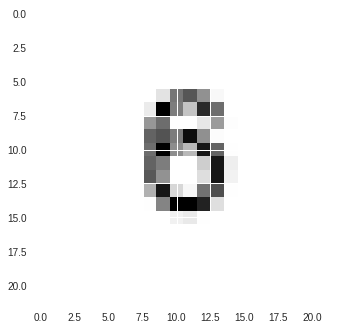

In [1]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
from PIL import Image


file_id = '13M-dLDt5hmG3bxmfBol_W5UnjyGU40lK'

import io
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()
downloaded.seek(0)
img_str = downloaded.read()
dd = io.BytesIO(img_str)
# downloaded.seek(0)
# file = downloaded.read()

# import locale
# locale.getdefaultlocale()
# file1_open = open(file, encoding=locale.getdefaultlocale()[1])
# file1_content = file1_open.read()

# print('Downloaded file contents are: {}'.format(file1_content))
pil_im = Image.open(dd)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

size = 28,28
pil_im.thumbnail(size, Image.ANTIALIAS)

imgplot = plt.imshow(pil_im)

# print('Downloaded file contents are: {}'.format(downloaded.read()))

In [0]:
# get opencv
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

from scipy import ndimage

TODO: FIX
https://medium.com/@o.kroeger/tensorflow-mnist-and-your-own-handwritten-digits-4d1cd32bbab4

In [0]:
# image proc
nparr = np.fromstring(img_str, np.uint8)

img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

gray = cv2.resize(255-img, (28,28))
(thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

while np.sum(gray[0]) == 0:
    gray = gray[1:]

while np.sum(gray[:,0]) == 0:
    gray = np.delete(gray,0,1)

while np.sum(gray[-1]) == 0:
    gray = gray[:-1]

while np.sum(gray[:,-1]) == 0:
    gray = np.delete(gray,-1,1)

rows,cols = gray.shape

if rows > cols:
    factor = 20.0/rows
    rows = 20
    cols = int(round(cols*factor))
    gray = cv2.resize(gray, (cols,rows))
else:
    factor = 20.0/cols
    cols = 20
    rows = int(round(rows*factor))
    gray = cv2.resize(gray, (cols, rows))

colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')

def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty
def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted
gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
shiftx,shifty = getBestShift(gray)
shifted = shift(gray,shiftx,shifty)
gray = shifted


flatten = gray.flatten() / 255.0
img_asarr = np.zeros((1,784))

img_asarr[0] = flatten



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [0]:
# gray = cv2.imread(dd, cv2.IMREAD_GRAYSCALE)

# file_bytes = np.asarray(bytearray(dd), dtype=np.uint8)
# nparr = np.fromstring(img_str, np.uint8)

# img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

# gray = cv2.resize(255-img, (28,28))
# flatten = gray.flatten() / 255.0
# img_asarr = np.zeros((1,784))
# img_asarr[0] = flatten

# corvals = np.zeros((1,10))
# corval = np.zeros((10))
# corval[6] = 1
# corvals[0] = corval

# print x, y_

# pred = tf.argmax(y,1)

tf.initialize_all_variables().run()
with tf.Session() as sess:
  tf.initialize_all_variables().run()
  label = sess.run(y, 
                   feed_dict={x: img_asarr})
  print label
#   print sess.run(pred, feed_dict={x: img_asarr, y_: corvals})
#   print sess.run(accuracy, feed_dict={x: img_asarr, y_: corvals})



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


Tensor("Placeholder:0", shape=(?, 784), dtype=float32) Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [0]:
print len(mnist.test.images[0])
# x = tf.Variable(pil_im, name='x')
# print x
# x = tf.reshape(x, shape=[-1])
# print x
# im = double(rgb2gray(pil_im))
# im = im(:)
# im = im./max(im)
# x = im
# x = pil_im
# x = tf.image.encode_png(x)
# x = np.array(x)
# x = x.ravel()
# x = tf.placeholder(x)
from array import *
# data_image = array('B')
# pixel = pil_im.load()
# width, height = pil_im.size

# for x in range(0,width):
#   for y in range(0,height):
#     data_image.append(pixel[y,x])

# x = data_image


# imagedata = np.zeros((-1,28,28), dtype=np.uint8)
# import matplotlib.image as imagick
# x = imagick.inread(pil_im)
# x = x.shape

# x = np.array(x, dtype=np.uint8)
# x = x.shape
# x = x.ravel()
# x = hash(tuple(x))
# x = np.matrix(x)

with tf.Session() as sess:
  new_image_label= sess.run(y, 
                            feed_dict={x: dd})
print new_image_label

784


InternalError: ignored

# Glossary and links

Difference between trainers well explained  
https://stackoverflow.com/questions/36162180/gradient-descent-vs-adagrad-vs-momentum-in-tensorflow

Sourcefor nielsennet
https://medium.com/initialized-capital/we-need-to-go-deeper-a-practical-guide-to-tensorflow-and-inception-50e66281804f
https://github.com/initialized/tensorflow-tutorial/blob/master/mnist-slim/MNIST%20Slim.ipynb


TODO: figure out mcdnn
https://arxiv.org/pdf/1202.2745.pdf
https://stackoverflow.com/questions/41990014/load-multiple-models-in-tensorflow